In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import k3d
import matplotlib.pyplot as plt
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

/Users/lukas/code/sloppy/src/sloppy/optic.py:348: SyntaxWarning: invalid escape sequence '\s'
  """Free form radially symmetric optic of the form z = \sum_i=0^deg coef[i] r**i
/Users/lukas/code/sloppy/src/sloppy/optic.py:371: SyntaxWarning: invalid escape sequence '\s'
  """Free form radially symmetric optic of the form z = \sum_i=0^deg coef[i] r**i
/Users/lukas/code/sloppy/src/sloppy/optic.py:420: SyntaxWarning: invalid escape sequence '\s'
  """Free form radially symmetric optic of the form z = \sum_i=0^deg coef[i] r**i


In [9]:
class DirectionalABCDSystem:
    """Manages ABCD calculations for an optical system with directionality."""
    
    def __init__(self, elements, source_index=None):
        # if there is no source index, find the source element
        if source_index is None:
            for i, el in enumerate(elements):
                if isinstance(el, Screen):
                    source_index = i
                    break

        self.elements = elements
        self.source_index = source_index
        
        # Verify we have a Source element
        if not isinstance(elements[source_index], Screen):
            raise ValueError("Element at source_index must be a Source")
    
    def calculate_abcd(self):
        """Calculate the ABCD matrix respecting element order and direction."""
        abcd_matrices = []
        
        # Start from element after source
        for i in range(1, len(self.elements)):
            prev_el = self.elements[i-1]
            curr_el = self.elements[i]
            # Calculate direction vector from previous to current element
            direction = norm(curr_el.p - prev_el.p)
            
            # Calculate propagation distance
            d = np.linalg.norm(curr_el.p - prev_el.p)
            
            aligned_with_normal = np.dot(direction, prev_el.n) > 0
            # print('directions ',curr_el, curr_el.p, prev_el.p, direction, aligned_with_normal)

            # Determine propagation index based on previous element
            n_prop = 1.0  # Default to air
            if isinstance(prev_el, Glass):
                # Determine which index to use based on ray direction
                n_prop = prev_el.n1 if aligned_with_normal else prev_el.n2

            print('n_prop from ', prev_el, 'to ', curr_el, 'is ', n_prop)
            # Add propagation matrix
            abcd_matrices.append(Prop(d, n=n_prop))
            
            # Add element's ABCD matrix
            _m = curr_el.get_abcd(direction)
            abcd_matrices.append(ABCD(_m))
            print('M ', curr_el, _m)
            
            # Add any basis rotation
            abcd_matrices.append(ABCD(curr_el.Rbasis))
        
        return abcd_matrices, ABCDSystem(abcd_matrices)

In [10]:
source = Screen(p=(0, 0, 0), n=(0, 0, -1), ax=(-1, 0, 0), diameter=10.0)

# Define other elements (simplified example)
lens1 = Glass(p=(0, 0, 10), n=(0, 0, -1), ax=(-1, 0, 0), diameter=25.4, n1=1.0, n2=1.5)

lens2 = CurvedGlass(p=(0, 0, 15), n=(0, 0, -1), ax=(-1, 0, 0), diameter=25.4, R=10, curv='CC', n1=1.5, n2=1.0)

mirror = Mirror(p=(0, 0, 30), n=(0, 0, -1), ax=(-1, 0, 0), diameter=25.4)

# Create system with the source at index 0
elements = [source, lens1, lens2, mirror, lens2, lens1, source]
sys = DirectionalABCDSystem(elements)

In [11]:
asphere2 = ThorlabsAsphere(p=(0, 0, 15), n=(0, 0, -1), ax=(-1, 0, 0), diameter=25.4, coef=[10, -1.550451e-1, 0, 0],  n1=1.5, n2=1.0)
elements_asphere = [source, lens1, asphere2, mirror, asphere2, lens1, source]
sys_asphere = DirectionalABCDSystem(elements_asphere)
abcd_asphere, system_asphere = sys_asphere.calculate_abcd()

n_prop from  <sloppy.optic.Screen object at 0x158208320> to  <sloppy.optic.Glass object at 0x15820ac90> is  1.0
M  <sloppy.optic.Glass object at 0x15820ac90> [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.66666667 0.        ]
 [0.         0.         0.         0.66666667]]
n_prop from  <sloppy.optic.Glass object at 0x15820ac90> to  <sloppy.optic.ThorlabsAsphere object at 0x1582097c0> is  1.5
M  <sloppy.optic.ThorlabsAsphere object at 0x1582097c0> [[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [-0.05  0.    1.5   0.  ]
 [ 0.   -0.05  0.    1.5 ]]
n_prop from  <sloppy.optic.ThorlabsAsphere object at 0x1582097c0> to  <sloppy.optic.Mirror object at 0x15820a030> is  1.0
M  <sloppy.optic.Mirror object at 0x15820a030> [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
n_prop from  <sloppy.optic.Mirror object at 0x15820a030> to  <sloppy.optic.ThorlabsAsphere object at 0x1582097c0> is  1.0
M  <sloppy.opti

In [12]:
mla = MicroLensArray(p=(0, 0, 15), n=(0, 0, -1), ax=(-1, 0, 0), diameter=25.4, R=10, curv='CC', n1=1.5, n2=1.0)
elements_mla = [source, lens1, mla, mirror, mla, lens1, source]
sys_mla = DirectionalABCDSystem(elements_mla)
abcd_mla, system_mla = sys_mla.calculate_abcd()

n_prop from  <sloppy.optic.Screen object at 0x158208320> to  <sloppy.optic.Glass object at 0x15820ac90> is  1.0
M  <sloppy.optic.Glass object at 0x15820ac90> [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.66666667 0.        ]
 [0.         0.         0.         0.66666667]]
n_prop from  <sloppy.optic.Glass object at 0x15820ac90> to  <sloppy.optic.MicroLensArray object at 0x15820a630> is  1.5
M  <sloppy.optic.MicroLensArray object at 0x15820a630> [[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [-0.05  0.    1.5   0.  ]
 [ 0.   -0.05  0.    1.5 ]]
n_prop from  <sloppy.optic.MicroLensArray object at 0x15820a630> to  <sloppy.optic.Mirror object at 0x15820a030> is  1.0
M  <sloppy.optic.Mirror object at 0x15820a030> [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
n_prop from  <sloppy.optic.Mirror object at 0x15820a030> to  <sloppy.optic.MicroLensArray object at 0x15820a630> is  1.0
M  <sloppy.optic.Mi

In [13]:
abcd, system = sys.calculate_abcd()

n_prop from  <sloppy.optic.Screen object at 0x158208320> to  <sloppy.optic.Glass object at 0x15820ac90> is  1.0
M  <sloppy.optic.Glass object at 0x15820ac90> [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.66666667 0.        ]
 [0.         0.         0.         0.66666667]]
n_prop from  <sloppy.optic.Glass object at 0x15820ac90> to  <sloppy.optic.CurvedGlass object at 0x15820b3e0> is  1.5
M  <sloppy.optic.CurvedGlass object at 0x15820b3e0> [[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [-0.05  0.    1.5   0.  ]
 [ 0.   -0.05  0.    1.5 ]]
n_prop from  <sloppy.optic.CurvedGlass object at 0x15820b3e0> to  <sloppy.optic.Mirror object at 0x15820a030> is  1.0
M  <sloppy.optic.Mirror object at 0x15820a030> [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
n_prop from  <sloppy.optic.Mirror object at 0x15820a030> to  <sloppy.optic.CurvedGlass object at 0x15820b3e0> is  1.0
M  <sloppy.optic.CurvedGlass ob

In [14]:
system.is_stable

True

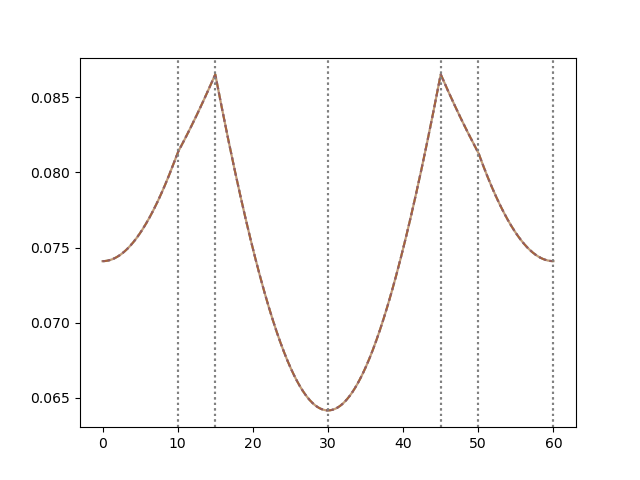

In [17]:
x = np.linspace(0, system.Ltot, 5000)
ws = system.compute_waists(x)
ws_asphere = system_asphere.compute_waists(x)
ws_mla = system_mla.compute_waists(x)
plt.figure()
plt.plot(x, ws, alpha=0.5)
plt.plot(x, ws_asphere, ls='--', alpha=0.5)
plt.plot(x, ws_mla, ls=':', alpha=0.5)



for i, e in enumerate(system.elements):
    if type(e)!=Prop:
        plt.axvline(e.x, color='grey', ls=':')
# plt.yscale('log')
plt.show()

In [9]:
pos = [e.p for e in sys.elements]

abcd = []
for i, el in enumerate(sys.elements):
    if i>0:
        d = np.linalg.norm(pos[i-1]-pos[i])
    else:
        d = 0
    if isinstance(el, Glass) or isinstance(el, ThorlabsAsphere) or isinstance(el, CurvedGlass) or isinstance(el, MicroLensArray):
        info = f" n1={el.n1}, n2={el.n2}"
        if hasattr(el, 'Reff'):
            info += f", R={el.Reff}"
    else:
        info = ""
        
    print(i, el, d, info)
    if isinstance(el, Glass) or isinstance(el, CurvedGlass) or isinstance(el, FreeFormInterface) or isinstance(el, ThorlabsAsphere):
        #modify index of refraction in propagation according to Glass element
        abcd.extend([Prop(d, n=el.n1), ABCD(el.m), ABCD(el.Rbasis)])
    else:
        abcd.extend([Prop(d), ABCD(el.m), ABCD(el.Rbasis)])

0 <sloppy.optic.Source object at 0x1041f43e0> 0 
1 <sloppy.optic.Glass object at 0x104411f10> 10.0  n1=1.0, n2=1.5
2 <sloppy.optic.CurvedGlass object at 0x10f670f50> 10.0  n1=1.5, n2=1.0, R=50
3 <sloppy.optic.Mirror object at 0x155f65430> 10.0 
4 <sloppy.optic.CurvedGlass object at 0x10f670f50> 10.0  n1=1.5, n2=1.0, R=50
5 <sloppy.optic.Glass object at 0x104411f10> 10.0  n1=1.0, n2=1.5
6 <sloppy.optic.Source object at 0x1041f43e0> 10.0 
